In [1]:
import numpy as np
import awkward as ak
import warnings
import matplotlib.pyplot as plt
import hist
import math
import os
import json
import gc
import dask_awkward as dak
import mplhep as hep

In [2]:
plt.style.use(hep.style.CMS)

In [3]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'divide by')
warnings.filterwarnings('ignore', 'overflow encountered')
warnings.filterwarnings('ignore', 'Conversion of an array')

In [4]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open('../../event_totals.json', 'r') as f:
    totals = json.load(f)

In [5]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [6]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [7]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [8]:
def read_files(input_path):
    if ('.parquet' in os.listdir(input_path)[0]):
        output = ak.from_parquet(f'{input_path}/new*', columns=columns)
    else:
        output = {}
        for i in os.listdir(input_path):
            if ('flat400' not in i) and ('hww' not in i):
                output[i] = ak.from_parquet(f'{input_path}/{i}/new*', columns=columns)
            else:
                continue
    return output

In [9]:
totals['ww'] = totals['diboson_ww']
totals['wz'] = totals['diboson_wz']
totals['zz'] = totals['diboson_zz']

In [10]:
region = 'nolepton'
path = '/cms/cephfs/data/store/user/cmoore24/skims/old/full_skims/'

In [11]:
def add_ratio(ratio, dataframe):
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[:dash]
    denominator = ratio[dash+1:asterisk]
    exponent = float(ratio[asterisk+2:])
    num_ecf = dataframe[numerator]
    den_ecf = dataframe[denominator]
    ecf_ratio = (num_ecf / (den_ecf**exponent))   
    return ecf_ratio

In [12]:
def get_num_den(ratio):
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[:dash]
    denominator = ratio[dash+1:asterisk]  
    return (numerator, denominator)

In [13]:
def firsts(mc):
    for i in mc:
        if type(mc[i]) == dict:
            for j in mc[i]:
                for k in mc[i][j].fields:
                    if 'event' in k:
                        continue
                    else:
                        try:
                            mc[i][j][k] = ak.firsts(mc[i][j][k])
                        except:
                            continue
        else:
            for j in mc[i].fields:
                if 'event' in j:
                    continue
                else:
                    try:
                        mc[i][j] = ak.firsts(mc[i][j])
                    except:
                        continue
    return mc

In [15]:
ecf_list = dak.from_parquet('/cms/cephfs/data/store/user/cmoore24/skims/old/full_skims/nolepton/mc/hgg/new*').groomed_ecfs.fields

In [16]:
ratios = []
for i in range(len(ecf_list)):
    if ecf_list[i][2] == 'e':
        n1 = int(ecf_list[i][3])
        a = int(ecf_list[i][:2])
    else:
        n1 = int(ecf_list[i][2])
        a = int(ecf_list[i][0])
    for j in range(len(ecf_list)):
        if ecf_list[i] == ecf_list[j]:
            continue
        if ecf_list[j][2] == 'e':
            n2 = int(ecf_list[j][3])
            b = int(ecf_list[j][:2])
        else:
            n2 = int(ecf_list[j][2])
            b = int(ecf_list[j][0])
        if n1 < n2:
            continue
        else:
            beta1 = float(ecf_list[i][-2:])
            beta2 = float(ecf_list[j][-2:])
            exponent = (a * beta1) / (b * beta2)
            ratios.append(f'{ecf_list[i]}/{ecf_list[j]}**{exponent}')

In [17]:
upper = 1000
lower = 450
IL = 44.99

In [18]:
def ecf_hist(dataset, ecf_min, ecf_max):
    make_hist = hist.Hist.new.Reg(40, ecf_min, ecf_max, name='ECF', label='MC ECF').Weight()
    make_hist.fill(ECF=dataset)
    return make_hist

In [108]:
# ratio = ratios[17025]
ratio = '1e520/1e510**2.0'
#ratio = '1e435/1e405**7.0'

In [109]:
groom_choice = 'groomed'

In [110]:
numerator, denominator = get_num_den(ratio)
numerator, denominator

('1e520', '1e510')

In [111]:
columns=['goodjets.msoftdrop', 'goodjets.pt', (f"{groom_choice}_ecfs", f'{numerator}'), (f"{groom_choice}_ecfs", f'{denominator}')]
mc = read_files(f'{path}/{region}/mc')

In [112]:
mc['ww'] = mc['diboson_ww']
mc['wz'] = mc['diboson_wz']
mc['zz'] = mc['diboson_zz']

In [113]:
del(mc['diboson_ww'])
del(mc['diboson_wz'])
del(mc['diboson_zz'])

In [114]:
mc = firsts(mc)

In [115]:
data = read_files(f'{path}/{region}/data')
data = firsts(data)

In [116]:
for i in xsecs:
    if ('wlnu' in i) or ('hww' in i):
        continue
    elif type(mc[i]) == dict:
        for j in mc[i]:
            mask = ((mc[i][j].goodjets.pt >= lower) & (mc[i][j].goodjets.pt <= upper))
            mc[i][j] = mc[i][j][mask]
    else:
        mask = ((mc[i].goodjets.pt >= lower) & (mc[i].goodjets.pt <= upper))
        mc[i] = mc[i][mask]

In [117]:
for i in data:
    if type(data[i]) == dict:
        for j in data[i]:
            mask = ((data[i][j].goodjets.pt >= lower) & (data[i][j].goodjets.pt <= upper))
            data[i][j] = data[i][j][mask]
    else:
        mask = ((data[i].goodjets.pt >= lower) & (data[i].goodjets.pt <= upper))
        data[i] = data[i][mask]

In [118]:
data_s = {}
for i in data:
    if "Jet" in i:
        data_s[i] = data[i]  
data_arr = ak.concatenate([data[i] for i in data_s])

In [119]:
data_ratio = add_ratio(ratio, data_arr[f'{groom_choice}_ecfs'])

In [141]:
# ratio_max = np.nanpercentile(np.array(data_ratio), 100)
ratio_max = ak.max(data_ratio)
ratio_min = ak.min(data_ratio)

In [142]:
ratio_min, ratio_max

(181.3409460799511, 192279674163.30432)

In [143]:
data_hist = hist.Hist.new.Reg(40, ratio_min, ratio_max, name='Ratio', label='Data Ratio').Weight()
data_hist.fill(Ratio=data_ratio);

In [144]:
ratio_min, ratio_max = adjust_histogram_range(data_hist, data_ratio, ratio_min, ratio_max)
#data_ratio = data_ratio[data_ratio <= ratio_max]

Adjusting!


In [145]:
ratio_min, ratio_max

(181.3409460799511, 3877.6166962876114)

In [146]:
# ratio_max = 39153.0409134311 * 1000

In [147]:
data_hist = hist.Hist.new.Reg(40, ratio_min, ratio_max, name='Ratio', label='Data Ratio').Weight()
data_hist.fill(Ratio=data_ratio);

In [148]:
mc2 = {}
for i in xsecs:
    if ('wlnu' in i) or ('hww' in i):
        continue
    elif type(mc[i]) == dict:
        for j in mc[i]:
            mc2[j] = mc[i][j]
    else:
        mc2[i] = mc[i]
mc = mc2    

In [149]:
mc_ratios = {}
for i in mc:
    if type(mc[i]) == dict:
        for j in mc[i]:
            mc_ratios[j] = add_ratio(ratio, mc[i][j][f'{groom_choice}_ecfs'])
    else:
        mc_ratios[i] = add_ratio(ratio, mc[i][f'{groom_choice}_ecfs'])

In [150]:
# for i in mc_ratios:
#     mc_ratios[i] = mc_ratios[i][mc_ratios[i] <= ratio_max]

In [151]:
hists = {}
for i in mc:
    if type(mc[i]) == dict:
        hists[i] = {}
        for j in mc[i]:
            hists[i][j] = ecf_hist(mc_ratios[i][j], ratio_min, ratio_max)
    else:
        hists[i] = ecf_hist(mc_ratios[i], ratio_min, ratio_max)

In [152]:
# scaleHgg = ((IL*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
# hists['hgg'].view(flow=True)[:] *= scaleHgg

# scaleHbb = ((IL*(xsecs['hbb']*1000)*0.581)/(totals['hbb']))
# hists['hbb'].view(flow=True)[:] *= scaleHbb

In [153]:
for i in mc:
    scale = ((IL*(xsecs[i]*1000))/(totals[i]))
    hists[i].view(flow=True)[:] *= scale

mc_hist = sum(hists[i] for i in hists)

In [154]:
mc_values, mc_bins = mc_hist.to_numpy()
data_values, data_bins = data_hist.to_numpy()
mc_density = mc_values / mc_values.sum()
data_density = data_values / data_values.sum()
mc_cdf = np.cumsum(mc_density)
data_cdf = np.cumsum(data_density)
ks_statistic = np.max(np.abs(mc_cdf - data_cdf))
adjusted = -math.log10(ks_statistic)
adjusted

2.2670114881631913

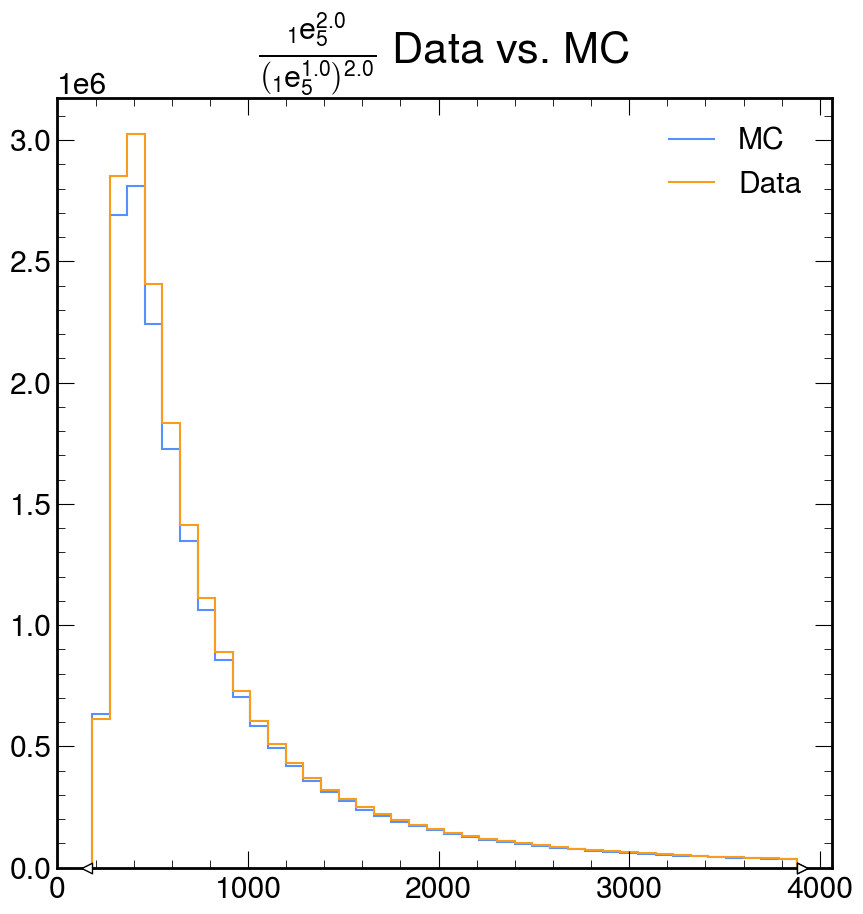

In [155]:
mc_hist.plot1d(label='MC', density=False, yerr=False)
data_hist.plot1d(label='Data', density=False, yerr=False)
plt.legend()
plt.title(r'$\frac{{}_{1}e_{5}^{2.0}}{\left({}_{1}e_{5}^{1.0}\right)^{2.0}}$ Data vs. MC')
plt.xlabel('')
plt.show()

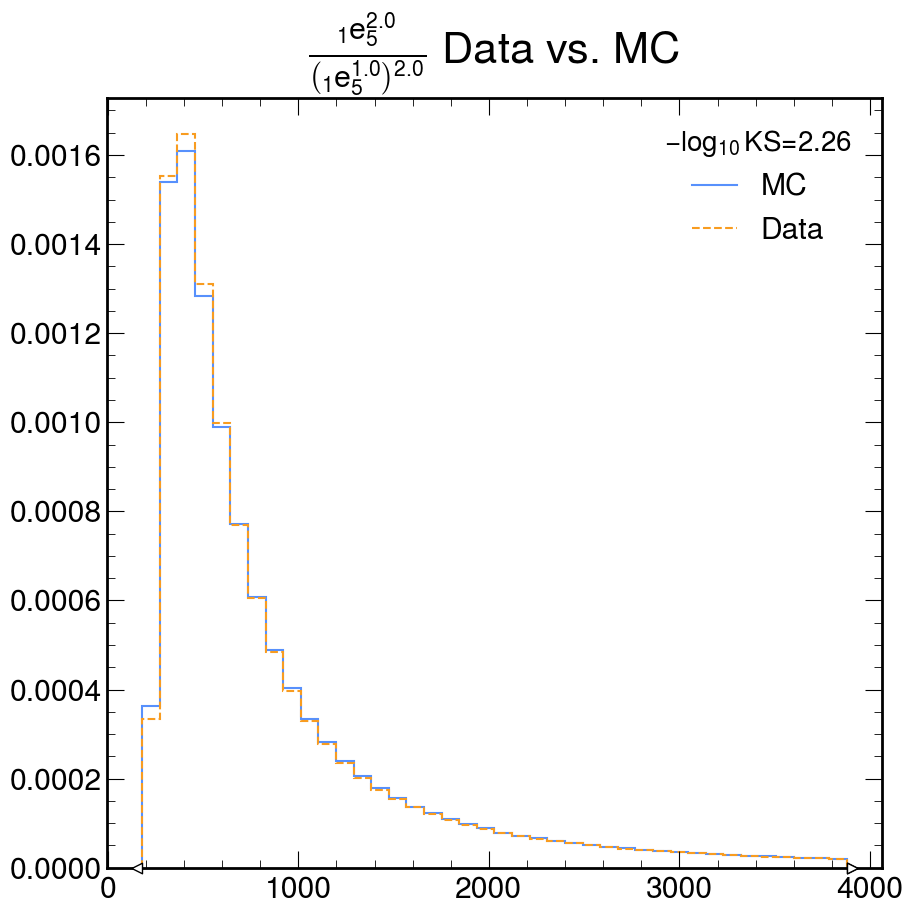

In [157]:
mc_hist.plot1d(label='MC', density=True, yerr=False)
data_hist.plot1d(label='Data', density=True, yerr=False, linestyle='--')
plt.legend(title=r'$-\log_{10}$KS=2.26', title_fontsize=20)
plt.title(r'$\frac{{}_{1}e_{5}^{2.0}}{\left({}_{1}e_{5}^{1.0}\right)^{2.0}}$ Data vs. MC')
plt.xlabel('')
plt.show()

In [ ]:
#GO THROUGH THE PASSING ONES AGAIN WITH 99% AS THE REQUIREMENT

In [33]:
def adjust_histogram_range(data_hist, data_ratio, ratio_min, ratio_max, percentile=99):
    bin_values, bin_edges = data_hist.to_numpy()
    total_entries = bin_values.sum()
    if np.any(bin_values > 0.60 * total_entries):
        print(bin_values[bin_values > 0.60 * total_entries]/total_entries)
        print('Adjusting!')
        new_max = np.nanpercentile(np.array(data_ratio), percentile)
        print(new_max)
        return ratio_min, new_max
    else:
        return ratio_min, ratio_max

In [140]:
def adjust_histogram_range(data_hist, data_ratio, ratio_min, ratio_max, percentile=95):
    bin_values, bin_edges = data_hist.to_numpy()
    total_entries = bin_values.sum()
    if np.any(bin_values > 0.60 * total_entries):
        print('Adjusting!')
        new_max = np.nanpercentile(np.array(data_ratio), percentile)
        return ratio_min, new_max
    else:
        return ratio_min, ratio_max